## Data preparation

In [1]:
import numpy as np
import xml.etree.ElementTree as ET
import math
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
tree = ET.parse('polska')
root = tree.getroot()

In [3]:
Nodes = {}
for node in root.findall(".//{http://sndlib.zib.de/network}node"):
    x = node.find(".//{http://sndlib.zib.de/network}x")
    y = node.find(".//{http://sndlib.zib.de/network}y")
    Nodes[node.get('id')] = [float(x.text), float(y.text)]
Nodes

{'Bialystok': [23.1, 53.1],
 'Bydgoszcz': [17.9, 53.1],
 'Gdansk': [18.6, 54.2],
 'Katowice': [18.8, 50.3],
 'Kolobrzeg': [16.1, 54.2],
 'Krakow': [19.8, 50.0],
 'Lodz': [19.4, 51.7],
 'Poznan': [16.8, 52.4],
 'Rzeszow': [21.9, 50.0],
 'Szczecin': [14.5, 53.4],
 'Warsaw': [21.0, 52.2],
 'Wroclaw': [16.9, 51.1]}

In [4]:
Links = {}
for link in root.findall(".//{http://sndlib.zib.de/network}link"):
    source = link.find(".//{http://sndlib.zib.de/network}source")
    target = link.find(".//{http://sndlib.zib.de/network}target")
    setupCost = link.find(".//{http://sndlib.zib.de/network}setupCost")
    
    longitudeS = Nodes[source.text][0]
    longitudeT = Nodes[target.text][0]
    latitudeS = Nodes[source.text][1]
    latitudeT = Nodes[target.text][1]
    
    #distance1 = math.sqrt((longitudeS - longitudeT)**2 + (latitudeS - latitudeT)**2) * 73
    distance2 = math.acos(math.sin(math.radians(latitudeS))*math.sin(math.radians(latitudeT)) + math.cos(math.radians(latitudeS))*
                          math.cos(math.radians(latitudeT))*math.cos(math.radians(longitudeT - longitudeS)) )* 6371
    Links[link.get('id')] = distance2

In [5]:
min(Links.values())

78.6728876043855

In [6]:
def addNodetoPath(node1, node2, input_list):
    if len(input_list) == 2 :
        if node1 in input_list and node1 == input_list[0] :
            #print('pierwszy przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node2)
            return input_list
        if node2 in input_list and node2 == input_list[0] :
            #print('drugi przypadek')
            second_node = input_list[1]
            input_list[1] = input_list[0]
            input_list[0] = second_node
            input_list.append(node1)
            return input_list  
    if node1 not in input_list : 
        input_list.append(node1)
    if node2 not in input_list : 
        input_list.append(node2)
        
    return input_list

In [7]:
n = 0
Y_values = []
input_list = []
for demand in root.findall(".//{http://sndlib.zib.de/network}demand"):
    source = demand.find(".//{http://sndlib.zib.de/network}source")
    target = demand.find(".//{http://sndlib.zib.de/network}target")
    demandValue = demand.find(".//{http://sndlib.zib.de/network}demandValue")
    #print(demand.attrib)
    print("Source: " + source.text)
    print("Target: " + target.text)
    print("DemandValue: " + demandValue.text)
    
    admissiblePaths = demand.findall(".//{http://sndlib.zib.de/network}admissiblePath")
    for path in admissiblePaths:
        path_links = path.findall(".//{http://sndlib.zib.de/network}linkId")
        values = 0;
        node_list=[]
        for link_id in path_links:
            values = values + 300./float(Links[link_id.text])
            words = link_id.text.split('_')
            node_list = addNodetoPath(words[1], words[2], node_list)
        input_list.append(node_list.copy()) 
        size = float(len(node_list))
        values= values + 300./min(Links.values())*(11-size)
        values = values + 10./(size-1)
        Y_values.append(values)
        n = n+1
        print(node_list)
        print(values)  
        node_list.clear()
"All paths: {}".format(n)

Source: Gdansk
Target: Bydgoszcz
DemandValue: 195.0
['0', '2', '1']
39.111775527610455
['0', '10', '1']
37.89570976324386
['0', '2', '9', '7', '1']
33.77412898818498
['0', '5', '10', '1']
33.98536367924393
['0', '10', '4', '3', '11', '7', '1']
29.721523571155718
['0', '2', '9', '7', '11', '3', '4', '10', '1']
24.68610440131703
['0', '5', '8', '4', '10', '1']
27.300950612745368
Source: Gdansk
Target: Kolobrzeg
DemandValue: 158.0
['0', '2']
46.16431196677906
['0', '10', '1', '2']
34.17650665740858
['0', '5', '10', '1', '2']
31.09949390674199
['0', '10', '4', '3', '11', '7', '1', '2']
27.430891893891868
['0', '10', '1', '7', '9', '2']
30.005526784649767
['0', '5', '8', '4', '10', '1', '2']
24.91508084024343
['0', '5', '10', '4', '3', '11', '7', '1', '2']
25.008641047987183
Source: Gdansk
Target: Katowice
DemandValue: 174.0
['0', '5', '8', '4', '3']
32.97309041124482
['0', '10', '4', '3']
36.09510728532111
['0', '5', '10', '4', '3']
33.018094534654516
['0', '5', '8', '4', '10', '6', '3']
2

'All paths: 462'

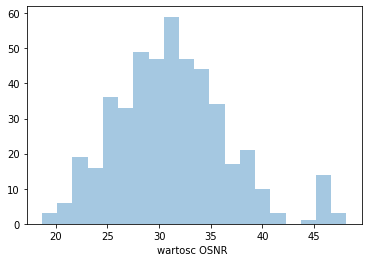

In [39]:
xs = pd.Series(Y_values,name="wartosc OSNR ")
sns.distplot(xs,bins=20, kde=False);

In [10]:
"All paths: {}".format(n)

'All paths: 462'

In [11]:
[i for (i,v) in zip(input_list, Y_values) if v>40]

[['0', '2'],
 ['0', '5'],
 ['0', '10'],
 ['1', '2'],
 ['1', '7'],
 ['1', '10'],
 ['1', '7', '11'],
 ['2', '1', '7'],
 ['2', '9'],
 ['3', '4'],
 ['3', '6'],
 ['3', '4', '8'],
 ['3', '4', '10'],
 ['3', '11'],
 ['4', '3', '6'],
 ['4', '8'],
 ['4', '10'],
 ['4', '3', '11'],
 ['5', '8'],
 ['5', '10'],
 ['6', '10'],
 ['6', '11'],
 ['7', '9'],
 ['7', '11']]

## Some statistics

In [41]:
print("Min: {}".format(min(Y_values)))
print("Max: {}".format(max(Y_values)))
print("Mean: {}".format(statistics.mean(Y_values)))

Min: 18.680154700631682
Max: 48.13257770689441
Mean: 31.264953871433754


## Calculate OSNR values

In [15]:
Y_output = np.array(Y_values)
Y_output.shape

(462,)

In [16]:
delimit_values=np.quantile(Y_output, [0.25,0.5,0.75])
delimit_values

array([27.69028916, 30.95785005, 34.4318863 ])

In [17]:
Y_output[Y_output<=delimit_values[0]]=0
Y_output[(Y_output>delimit_values[0]) & (Y_output<=delimit_values[1])]=1
Y_output[(Y_output>delimit_values[1]) & (Y_output<=delimit_values[2])]=2
Y_output[Y_output>delimit_values[2]]=3
Y_output

array([3., 3., 2., 2., 1., 0., 0., 3., 2., 2., 0., 1., 0., 0., 2., 3., 2.,
       0., 1., 3., 2., 2., 3., 2., 2., 3., 2., 1., 3., 3., 2., 1., 1., 0.,
       0., 1., 3., 3., 1., 1., 2., 2., 3., 3., 3., 0., 2., 2., 1., 3., 2.,
       2., 1., 2., 1., 0., 3., 2., 2., 1., 1., 2., 0., 3., 3., 3., 1., 1.,
       1., 0., 2., 1., 2., 1., 2., 1., 0., 3., 3., 2., 0., 2., 0., 0., 1.,
       0., 1., 1., 1., 0., 3., 1., 0., 1., 2., 1., 3., 3., 3., 1., 0., 2.,
       3., 1., 1., 0., 0., 1., 2., 1., 0., 0., 3., 3., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 0., 3., 2., 3., 3., 0., 2., 0., 0., 0., 3., 3., 1.,
       0., 2., 2., 1., 3., 0., 0., 2., 2., 1., 0., 1., 2., 2., 1., 0., 1.,
       2., 2., 2., 2., 2., 1., 2., 2., 3., 3., 3., 1., 1., 1., 1., 1., 3.,
       3., 2., 0., 0., 2., 3., 3., 1., 2., 1., 0., 1., 2., 2., 2., 1., 1.,
       2., 2., 3., 3., 1., 0., 0., 0., 0., 3., 3., 3., 2., 1., 1., 1., 3.,
       1., 2., 3., 1., 1., 0., 3., 3., 0., 0., 1., 2., 0., 3., 3., 3., 1.,
       0., 2., 2., 3., 3.

In [18]:
X_input = np.full((462,11), -1)
X_input.shape

(462, 11)

In [19]:
n = 0
for path in input_list:
    for i in range(len(path)):
        X_input[n][i] = path[i]
    n =n+1

In [20]:
X_input

array([[ 0,  2,  1, ..., -1, -1, -1],
       [ 0, 10,  1, ..., -1, -1, -1],
       [ 0,  2,  9, ..., -1, -1, -1],
       ...,
       [10,  1,  7, ..., -1, -1, -1],
       [10,  6,  3, ..., -1, -1, -1],
       [10,  4,  8, ..., 11, -1, -1]])

## K-fold validation 

In [21]:
from sklearn.model_selection import KFold

In [22]:
kf=KFold(n_splits=20)
#kf.get_n_splits(X_input)

for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    print("Train: ", statistics.mean(Y_train), "Test: ", statistics.mean(Y_test))
        

438 24
438 24
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23
439 23


# random forest

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from matplotlib.pyplot import plot
import matplotlib.pyplot as plt

## Default values of parameters 

In [24]:
kf=KFold(n_splits=20)
#kf.get_n_splits(X_input)
accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = n_B, max_samples=n_B, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
print("Accuracy of the model: ",statistics.mean(accuracy))

Accuracy of the model:  0.7341485507246377


## Accuracy for different number of trees in random forest 

In [25]:
n_B=int(math.sqrt(len(X_train)*19/20))
n_B

20

In [26]:
B_values=[]
acc_values=[]
n_B=int(math.sqrt(len(X_train)*19/20))

for n in range(int(math.sqrt(n_B)),15*n_B, 2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators = n,max_depth=11, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values.append(statistics.mean(accuracy))
    B_values.append(n)
    

Text(0.5, 0, 'Liczba drzew')

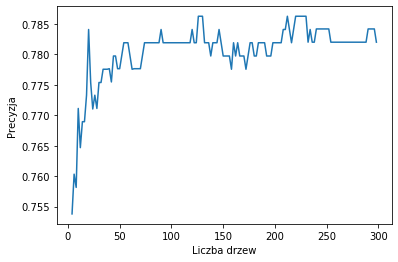

In [27]:
plot(B_values,acc_values)
plt.ylabel("Precyzja")
plt.xlabel("Liczba drzew")

In [28]:
best_treeN=[x for (x,y) in zip(B_values,acc_values) if y==max(acc_values)][0]
best_treeN

126

In [29]:
max(acc_values)

0.786231884057971

## Accuracy for different depths of trees

In [30]:
Depth_values=[]
acc_values1=[]

for n in range(1,12):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=n, max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values1.append(statistics.mean(accuracy))
    Depth_values.append(n)
    

Text(0.5, 0, 'Głębokość drzew')

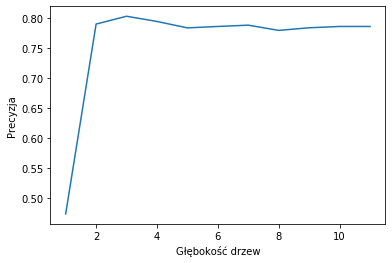

In [31]:
plot(Depth_values,acc_values1)
plt.ylabel("Precyzja")
plt.xlabel("Głębokość drzew")


In [32]:
best_depth=[x for (x,y) in zip(Depth_values,acc_values1) if y==max(acc_values1)][0]
best_depth

3

In [33]:
max(acc_values1)

0.8032608695652174

## Accuracy for different sizes of samples to draw from X to train each base estimator

In [34]:
B1_values=[]
acc_values2=[]

for n in range(int(math.sqrt(n_B)),300,2):
    accuracy=[]
    for train_index, test_index in kf.split(X_input):
        X_train, X_test = X_input[train_index], X_input[test_index]
        Y_train, Y_test = Y_output[train_index], Y_output[test_index]
        n_B=int(math.sqrt(len(X_train)))
        rf = RandomForestRegressor(n_estimators =best_treeN, max_depth=best_depth, max_samples=n, bootstrap=True,max_features="auto", random_state = 42)
        rf.fit(X_train, Y_train);
        predictions = rf.predict(X_test)
        predictions=np.round(predictions,0)
        error= predictions==Y_test
        accuracy.append(np.sum(error)/len(error))
    acc_values2.append(statistics.mean(accuracy))
    B1_values.append(n)
    

Text(0.5, 0, 'Liczba obiektów użyta do budowy każdego z drzew')

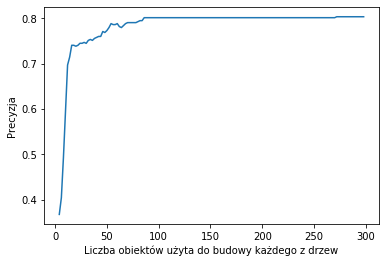

In [35]:
plot(B1_values,acc_values2)
plt.ylabel("Precyzja")
plt.xlabel("Liczba obiektów użyta do budowy każdego z drzew")

In [38]:
best_bootstrap=[x for (x,y) in zip(B1_values,acc_values2) if y>0.8][0]
print("Liczba obiektow:", best_bootstrap, "precyzja: ", max(acc_values2))


Liczba obiektow: 86 precyzja:  0.8032608695652174


## Model with optimal parameters

In [37]:

accuracy=[]
for train_index, test_index in kf.split(X_input):
    X_train, X_test = X_input[train_index], X_input[test_index]
    Y_train, Y_test = Y_output[train_index], Y_output[test_index]
    n_B=int(math.sqrt(len(X_train)))
    rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
    rf.fit(X_train, Y_train);
    predictions = rf.predict(X_test)
    predictions=np.round(predictions,0)
    error= predictions==Y_test
    accuracy.append(np.sum(error)/len(error))
#print(accuracy)
print("Accuracy of the model: ",round(statistics.mean(accuracy),4))

Accuracy of the model:  0.8012


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

In [64]:
X_train, X_test, Y_train, Y_test = train_test_split(X_input,Y_output, test_size=0.2)

rf = RandomForestRegressor(n_estimators = best_treeN, max_depth=best_depth, max_samples=best_bootstrap,bootstrap=True, max_features="auto", random_state = 42)
rf.fit(X_train, Y_train);
predictions = rf.predict(X_test)
predictions=np.round(predictions,0)
error= predictions==Y_test
print(np.sum(error)/len(error))

0.8172043010752689


Confusion Matrix for Random Forest
[[18  6  0  0]
 [ 1 24  1  0]
 [ 0  4 14  4]
 [ 0  0  1 20]]


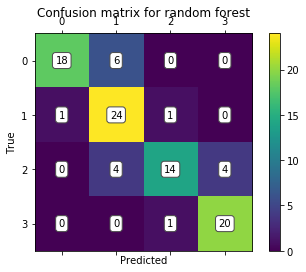

In [72]:
print('Confusion Matrix for Random Forest')
cm=confusion_matrix(Y_test, predictions)
print(cm)
labels=[0,1,2,3]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:d}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
plt.title('Confusion matrix for random forest')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()